## Imports

In [5]:
import os,sys
import cv2
from tqdm import tqdm
import re
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory

# VGG16 import
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16

# VGG19 import
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19

# inception_v3 import
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_incv3, InceptionV3

#extra
from tensorflow.keras.layers import Input

# Inception model

In [6]:
# path for kaggle
train_dir = '/kaggle/input/stanford-dogs-dataset-traintest/cropped/train'
test_dir = "/kaggle/input/stanford-dogs-dataset-traintest/cropped/test"

In [7]:
# load train
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32)

#preprocess train
prep_train_ds = train_ds.map(lambda x, y: (preprocess_input_incv3(x), y))

Found 12000 files belonging to 120 classes.
Using 9600 files for training.


In [8]:
# load val
validation_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32)

#preprocess val
prep_val_ds = validation_ds.map(lambda x, y: (preprocess_input_incv3(x), y))

Found 12000 files belonging to 120 classes.
Using 2400 files for validation.


In [9]:
# load test
test_ds = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    batch_size=32)

#preprocess test
prep_test_ds = test_ds.map(lambda x, y: (preprocess_input_incv3(x), y))

Found 8580 files belonging to 120 classes.


In [12]:
# specifying the shape for the input layer
input_shape = train_ds.element_spec[0].shape[1:] #(224, 224, 3)
input_tensor = Input(shape=input_shape)

In [13]:
# inception is a base model
base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
# Freeze the base model layers to prevent them from being updated during training
base_model.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


## 2 dense layers 100 neurons, ~86% test acc

In [10]:
def model_init():
    augmentation = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomRotation(0.1)
    ])

    augment_model = Sequential([
        layers.Input(shape = input_shape),
        augmentation,
        base_model,
        layers.Flatten(),
        layers.Dense(100, activation="relu"),
        layers.Dense(100, activation="relu"),
        layers.Dense(120, activation='softmax')
    ])
    return augment_model

In [11]:
augment_model = model_init()
augment_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 100)               5120100   
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 120)               12120     
                                                                 
Total params: 26,945,104
Trainable params: 5,142,320
N

In [12]:
opt = optimizers.Adam(learning_rate = 1e-4)

def compile_model(model):
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [14]:
augment_model = compile_model(augment_model)

MODEL = "model_1"

epochs=20

es = EarlyStopping(monitor='val_loss', 
                   mode='auto', 
                   patience=3, 
                   verbose=1, 
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor="val_loss",
                       factor=0.1,
                       patience=2,
                       verbose=1,
                       min_lr=0)

mcp = ModelCheckpoint("{}.h5".format(MODEL),
                      save_weights_only=True,
                      monitor='val_accuracy',
                      mode='max',
                      verbose=0,
                      save_best_only=True)

history = augment_model.fit(prep_train_ds, 
                        validation_data=prep_val_ds, 
                        epochs=15,
                        callbacks=[es, lr, mcp],
                        batch_size=32,
                        verbose=1)

Epoch 1/15
300/300 [==============================] - 110s 338ms/step - loss: 2.6434 - accuracy: 0.4109 - val_loss: 0.8089 - val_accuracy: 0.7892 - lr: 1.0000e-04
Epoch 2/15
300/300 [==============================] - 93s 310ms/step - loss: 1.2953 - accuracy: 0.6708 - val_loss: 0.6320 - val_accuracy: 0.8225 - lr: 1.0000e-04
Epoch 3/15
300/300 [==============================] - 92s 306ms/step - loss: 1.1612 - accuracy: 0.6989 - val_loss: 0.6170 - val_accuracy: 0.8183 - lr: 1.0000e-04
Epoch 4/15
300/300 [==============================] - 91s 304ms/step - loss: 1.0598 - accuracy: 0.7197 - val_loss: 0.5960 - val_accuracy: 0.8158 - lr: 1.0000e-04
Epoch 5/15
300/300 [==============================] - 92s 305ms/step - loss: 0.9946 - accuracy: 0.7294 - val_loss: 0.5687 - val_accuracy: 0.8308 - lr: 1.0000e-04
Epoch 6/15
300/300 [==============================] - 93s 308ms/step - loss: 0.9437 - accuracy: 0.7376 - val_loss: 0.5621 - val_accuracy: 0.8346 - lr: 1.0000e-04
Epoch 7/15
300/300 [=======

In [15]:
loss, accuracy = augment_model.evaluate(prep_test_ds)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

269/269 [==============================] - 40s 144ms/step - loss: 0.4878 - accuracy: 0.8540
Test loss: 0.4878
Test accuracy: 0.8540


In [16]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

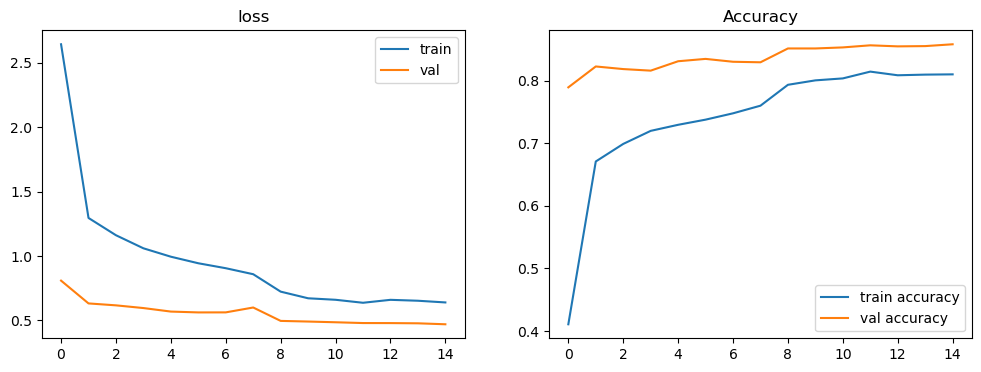

In [17]:
plot_history(history)

# Trying just one dense layer with different amount of neurons (no improvement)

## 1 dense layer 256 neurons

In [ ]:
def model_init():
    augmentation = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomRotation(0.1)
    ])

    augment_model_1 = Sequential([
        layers.Input(shape = input_shape),
        augmentation,
        base_model,
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dense(120, activation='softmax')
    ])
    return augment_model_1

In [ ]:
augment_model_1 = model_init()
augment_model_1.summary()

In [ ]:
opt = optimizers.Adam(learning_rate = 1e-4)

def compile_model(model):
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
augment_model_1 = compile_model(augment_model_1)

MODEL = "model_1"

epochs=20

es = EarlyStopping(monitor='val_loss', 
                   mode='auto', 
                   patience=5, 
                   verbose=1, 
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor="val_loss",
                       factor = 0.1,
                       patience=3,
                       verbose=1,
                       min_lr=0)

mcp = ModelCheckpoint("{}.h5".format(MODEL),
                      save_weights_only=True,
                      monitor='val_accuracy',
                      mode='max',
                      verbose=0,
                      save_best_only=True)

history_1 = augment_model_1.fit(prep_train_ds, 
                        validation_data=prep_val_ds, 
                        epochs=30,
                        callbacks=[es, lr, mcp],
                        batch_size=32,
                        verbose=1)

In [ ]:
loss, accuracy = augment_model_1.evaluate(prep_test_ds)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

In [ ]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs_range = range(19)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 1 dense layer 128 neurons

In [ ]:
def model_init():
    augmentation = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomRotation(0.1)
    ])

    augment_model_2 = Sequential([
        layers.Input(shape = input_shape),
        augmentation,
        base_model,
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(120, activation='softmax')
    ])
    return augment_model_2

In [ ]:
augment_model_2 = model_init()
augment_model_2.summary()

In [ ]:
opt = optimizers.Adam(learning_rate = 1e-4)

def compile_model(model):
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
augment_model_2 = compile_model(augment_model_1)

MODEL = "model_3_128"

epochs=20

es = EarlyStopping(monitor='val_loss', 
                   mode='auto', 
                   patience=4, 
                   verbose=1, 
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor="val_loss",
                       factor = 0.1,
                       patience=2,
                       verbose=1,
                       min_lr=0)

mcp = ModelCheckpoint("{}.h5".format(MODEL),
                      save_weights_only=True,
                      monitor='val_accuracy',
                      mode='max',
                      verbose=0,
                      save_best_only=True)

history_2 = augment_model_2.fit(prep_train_ds, 
                        validation_data=prep_val_ds, 
                        epochs=30,
                        callbacks=[es, lr, mcp],
                        batch_size=32,
                        verbose=1)

In [ ]:
loss, accuracy = augment_model_2.evaluate(prep_test_ds)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs_range = range(23)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()